## Import Libraries 📚

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as ply
import ipywidgets as widgets
import seaborn as sns

from itertools import cycle
# Set interactive backend
%matplotlib inline


cmap = mpl.cm.get_cmap('coolwarm')
sns.set_theme(style="white", palette=None)
color_pal = ply.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(ply.rcParams["axes.prop_cycle"].by_key()["color"])

/Users/alexkagozi/Desktop/AI/ArtificialIntelligence/BirdCLEF-2024/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/m9/m7xl4h0s4dxcq7r_gtrcb8m80000gn/T/ipykernel_1392/2778358693.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


### Data Exploration 💥💥

In [5]:
DATASET_PATH = 'content/birdclef-2024'

#### View the species name and construct a dictionary to hold their values 📃

In [6]:
class_names = sorted(os.listdir(f"{DATASET_PATH}/train_audio/"))
num_classes = len(class_names)
class_labels = list(range(num_classes))
label2name = dict(zip(class_labels, class_names))
name2label = {v:k for k,v in label2name.items()}

In [7]:
## Print out the first 5 items in the label2name and name2label dictionaries
print(f"Number of classes: {num_classes}")
print({k: label2name[k] for k in list(label2name)[:5]})
print({k: name2label[k] for k in list(name2label)[:5]})

Number of classes: 182
{0: 'asbfly', 1: 'ashdro1', 2: 'ashpri1', 3: 'ashwoo2', 4: 'asikoe2'}
{'asbfly': 0, 'ashdro1': 1, 'ashpri1': 2, 'ashwoo2': 3, 'asikoe2': 4}


### Load the dataframe 🔃

In [8]:
df = pd.read_csv(f'{DATASET_PATH}/train_metadata.csv')
df['filepath'] = DATASET_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

## display a few rows of the dataframe from columns ['scientific_name', 'scientific_name',  'filepath']
df = df.sample(frac=1, random_state=42)
df.head(5)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
3265,blrwar1,[],"['male', 'song']",50.4140,60.6285,Acrocephalus dumetorum,Blyth's Reed Warbler,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/184748,XC184748.ogg,content/birdclef-2024/train_audio/blrwar1/XC18...,20,XC184748
23387,whtkin2,[],[''],11.9632,75.5785,Halcyon smyrnensis,White-throated Kingfisher,JISHNU KIZHAKKILLAM,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/797017,XC797017.ogg,content/birdclef-2024/train_audio/whtkin2/XC79...,176,XC797017
14115,hoopoe,[],['song'],54.6929,28.2816,Upupa epops,Eurasian Hoopoe,Danuta Peplowska-Marczak,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/349675,XC349675.ogg,content/birdclef-2024/train_audio/hoopoe/XC349...,80,XC349675
12223,grnsan,[],"['NFC', 'Nocturnal flight call', 'flight call']",42.7285,2.9876,Tringa ochropus,Green Sandpiper,Quentin GIRAUDON,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/478932,XC478932.ogg,content/birdclef-2024/train_audio/grnsan/XC478...,71,XC478932
22099,tibfly3,[],"['duet', 'female', 'male', 'song']",8.9141,98.5096,Cyornis tickelliae,Tickell's Blue Flycatcher,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/645726,XC645726.ogg,content/birdclef-2024/train_audio/tibfly3/XC64...,161,XC645726


In [9]:
## Display the number of samples per class and save the result in a dictionary
class_counts = df.primary_label.value_counts()
class_counts = class_counts.sort_index()
class_counts
# ## Save to a csv file
# pd.DataFrame(class_counts.items(), columns=['class', 'count']).to_csv('class_counts.csv', index=False)

## Show the largest and smallest classes
class_counts_csv = pd.read_csv('class_counts.csv')
## Show the largest and smallest classes with the corresponding counts
# Find the minimum and maximum counts
min_count = class_counts.min()
max_count = class_counts.max()
 
print(f"Smallest class: {class_counts_csv['class'][class_counts_csv['count'].idxmin()]} {min_count}")
print(f"Largest class: {class_counts_csv['class'][class_counts_csv['count'].idxmax()]} {max_count}")

Smallest class: asiope1 5
Largest class: barswa 500


In [10]:
## Check the size of the dataframe
## The shape of the dataframe should be (24459, 15) which means there are 24459 rows and 15 columns
print(f"Dataframe shape: {df.shape}")

Dataframe shape: (24459, 15)


### Function to retreive an audio file 🎵
**librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems**
[Documentation here](https://librosa.org/doc/latest/index.html)

In [11]:
## Load the audio as a waveform `y`
# Store the sampling rate as `sr`
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

#### Visualizing audio data
A random audio file will be used

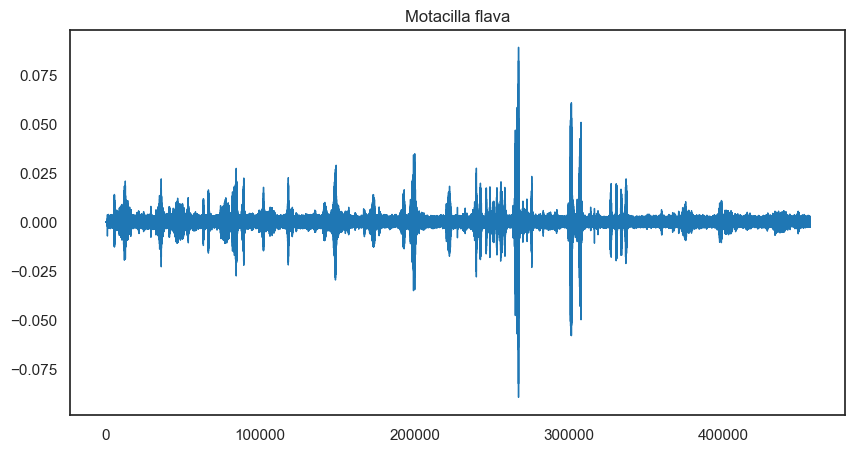

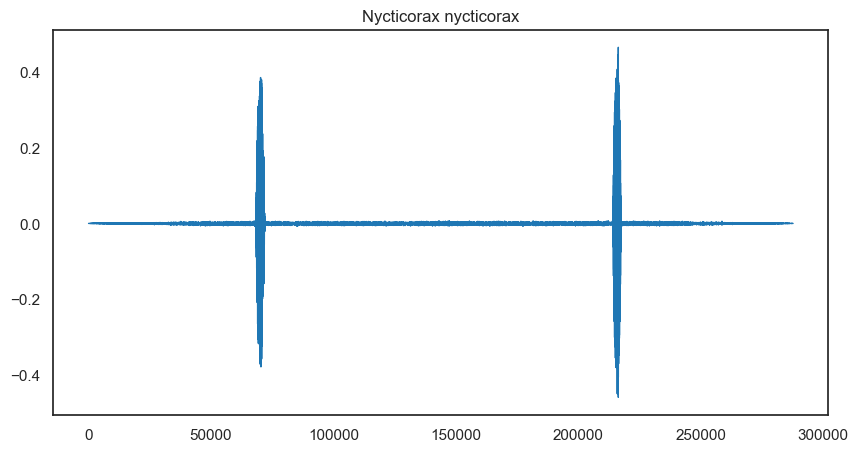

In [12]:
import random
for i in range(2):
    random_index = random.randint(0, df.shape[0])
    ipd.Audio(df['filepath'].iloc[random_index])
    audio, sr = load_audio(df['filepath'].iloc[random_index])
    plt.figure(figsize=(10, 3))
    pd.Series(audio).plot(figsize=(10, 5),
                    lw=1,
                    title=f"{df['scientific_name'].iloc[random_index]}",
                    color=color_pal[0])
    ## Zoomed in sample to view waves better:
    plt.show()


### From the plotted files, we can see that the bird recording occur where the amplitude (height) of the wave is high

#### Let's preview the shape of the audio data randomly as well

In [13]:
#### Understanding the audio data
for i in range(2):
    random_index = random.randint(0, df.shape[0])
    ipd.Audio(df['filepath'].iloc[random_index])
    audio, sr = load_audio(df['filepath'].iloc[random_index])
    print(f"Audio: {audio}")
    print(f"Shape of the audio: {audio.shape}")
## The audio file is a numpy array. However, the size of the arrays are different hence we need to pad/trim the arrays to make them the same size


Audio: [ 2.2587636e-05  1.5264568e-05 -5.0371909e-06 ...  5.5479381e-04
  3.8403060e-04  0.0000000e+00]
Shape of the audio: (687169,)
Audio: [-5.2027508e-06 -2.0546895e-05  3.5282826e-06 ... -1.0402429e-04
 -1.1234212e-04  0.0000000e+00]
Shape of the audio: (600193,)


#### Preview a sample of audio spectrograms
The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

(1025, 1678)


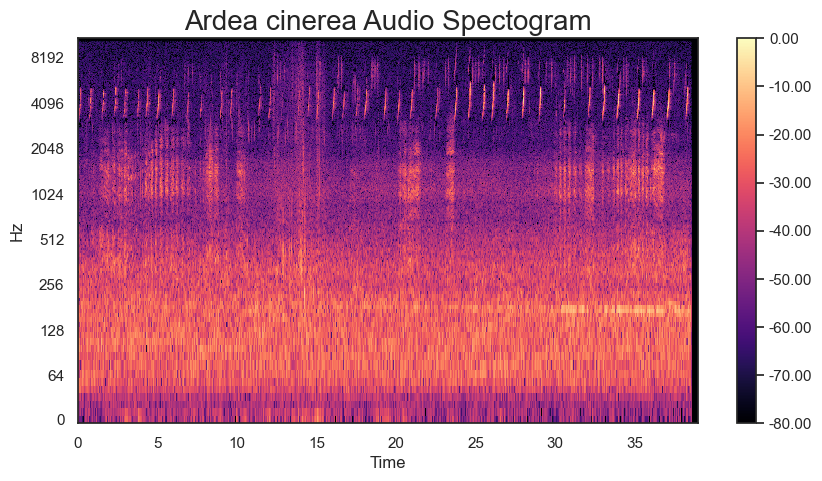

(1025, 15647)


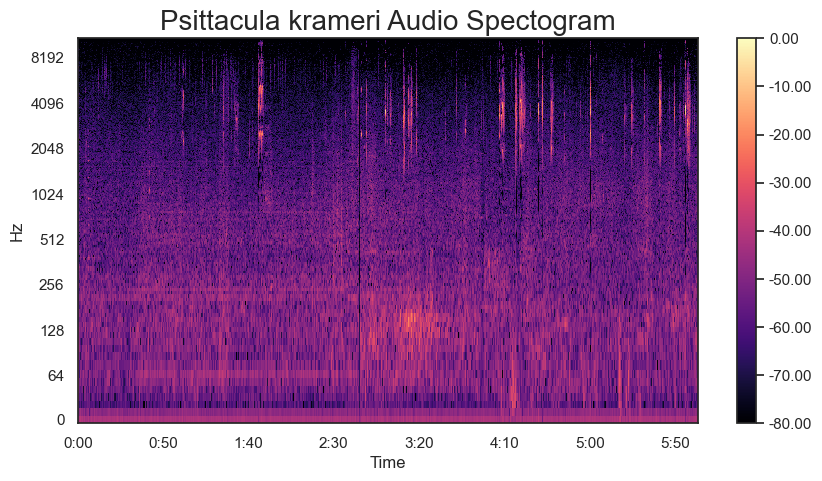

In [14]:
"""
 function to preview simple spectrograms in decibels. A decibel is a logarithmic unit that expresses 
 the ratio of two values of a physical quantity, often power or intensity.
 """
def audio_to_spectrogram(audio):
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    print(S_db.shape)

    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title(f"{df['scientific_name'].iloc[random_index]} Audio Spectogram", fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

for i in range(2):
    random_index = random.randint(0, df.shape[0])
    audio, sr = load_audio(df['filepath'].iloc[random_index])
    audio_to_spectrogram(audio)

(256, 473)


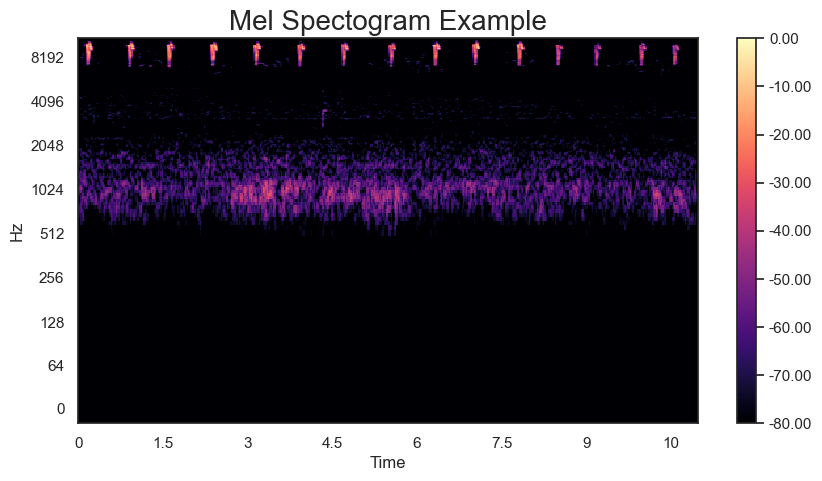

(256, 534)


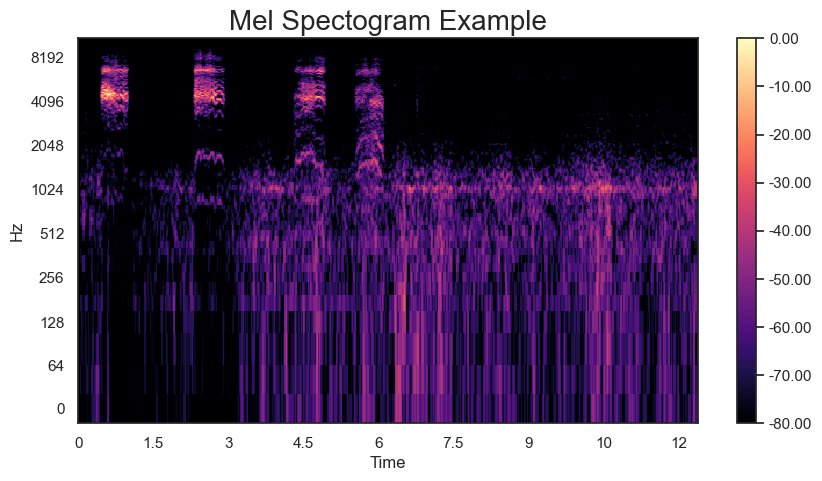

In [15]:
"""
While a regular spectrogram uses a linear frequency scale, 
a Mel spectrogram uses the Mel scale, which is designed to better reflect how humans perceive sound.
"""
def audio_to_melspectrogram(audio, sr):
    S = librosa.feature.melspectrogram(y=audio,
                                   sr=sr,
                                   n_mels=128 * 2,)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    print(S_db_mel.shape)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot the mel spectogram
    img = librosa.display.specshow(S_db_mel,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title('Mel Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

for i in range(2):
    random_index = random.randint(0, df.shape[0])
    audio, sr = load_audio(df['filepath'].iloc[random_index])
    audio_to_melspectrogram(audio, sr)

### Get the audio spectrogram 🌊. 
**A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams**

In [16]:
# Define the sampling rate of the audio signal (32 kHz)
sample_rate = 32000

# Define the maximum frequency to include in the spectrogram (16 kHz)
fmax = 16000

# Define the minimum frequency to include in the spectrogram (20 Hz)
fmin = 20

# Function to compute the Mel-spectrogram of an audio signal
def get_spectrogram(audio):
    # Compute the Mel-spectrogram
    spec = librosa.feature.melspectrogram(
        y=audio,  # Input audio signal
        sr=sample_rate,  # Sampling rate of the audio
        n_mels=256,  # Number of Mel bands (frequency bins)
        n_fft=2048,  # Size of the FFT window (determines frequency resolution)
        hop_length=512,  # Number of samples between successive frames (determines time resolution)
        fmax=fmax,  # Maximum frequency to include in the spectrogram
        fmin=fmin,  # Minimum frequency to include in the spectrogram
    )

    # Convert the power spectrogram to decibel (dB) scale
    # This makes the values more perceptually meaningful
    spec = librosa.power_to_db(spec, ref=1.0)  # ref=1.0 is the reference value for dB calculation

    # Normalize the spectrogram to the range [0, 1]
    min_ = spec.min()  # Minimum value in the spectrogram
    max_ = spec.max()  # Maximum value in the spectrogram
    if max_ != min_:  # Avoid division by zero if the spectrogram is constant
        spec = (spec - min_) / (max_ - min_)  # Normalize using min-max scaling

    print(spec.shape)
    # Return the normalized Mel-spectrogram
    return spec

### Display a few audio files with spectograms and their associated df details ⚡

In [17]:
duration = 15
audio_len = duration * sample_rate
def display_audio(row):
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name}'
    
    audio, sr = load_audio(row.filepath)
    audio = audio[:audio_len]
    spec = get_spectrogram(audio)
    
    # Audio output widget
    audio_output = widgets.Output()
    with audio_output:
        display(ipd.Audio(audio, rate=sample_rate))
    
    # Plot output widget
    plot_output = widgets.Output()
    with plot_output:
        fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, tight_layout=True)
        fig.suptitle(caption)
        
        # Plot waveform
        lid.waveshow(audio, sr=sample_rate, ax=ax[0], color='b')
        
        # Plot spectrogram
        lid.specshow(spec, sr=sample_rate, hop_length=512, n_fft=2048,
                     fmin=fmin, fmax=fmax, x_axis='time', y_axis='mel', 
                     cmap='coolwarm', ax=ax[1])
        
        ax[0].set_xlabel('')
        plt.show()

    # Display side-by-side
    display(widgets.HBox([audio_output, plot_output]))


In [18]:
## Display a few audio samples
for i in range(3):
    display_audio(df.sample(1).iloc[0])

(256, 246)


(256, 938)


(256, 310)


### Build a decoder parse files into spectrograms🚀 

**The build_decoder() function constructs a decoder that can process audio files into spectrograms.
It loads, normalizes, and converts the audio into a Mel-spectrogram.
If with_labels=True, it also converts labels into one-hot vectors.
The output is an RGB-like spectrogram image that can be used as input to CNNs.**
[Tensorflow Documentation here](https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram)

In [ ]:
# Image and audio parameters
img_size = [128, 384]  # Spectrogram image size (height, width)
batch_size = 64  # Batch size for training
## The hop length is the number of samples between successive frames. 
# The audio length is divided by the width of the image to determine the hop length
hop_length = audio_len // (img_size[1] - 1)  # What does this do? 
nfft = 2028  # FFT window size for computing the spectrogram

## Explain the parameters


def build_decoder(with_labels=True, dim=1024):
    """
    Builds a function to decode and preprocess audio files into spectrograms.
    
    Parameters:
    - with_labels (bool): Whether to return labels along with spectrograms.
    - dim (int): Target audio length (number of samples).
    
    Returns:
    - Function to decode audio files (with or without labels).
    """

    # def get_audio(filepath):
    #     """Loads and decodes an audio file from a given filepath."""
    #     file_bytes = tf.io.read_file(filepath)  # Read the audio file as bytes
    #     audio, sr = librosa.load(filepath, sr=None, mono=True)
    #     # audio = tf.cast(audio, tf.float32)  # Convert to float32
    #     audio = tf.convert_to_tensor(audio, dtype=tf.float32)

    #     # Convert stereo to mono by selecting only one channel
    #     # if tf.shape(audio)[1] > 1:
    #     #     audio = audio[..., 0:1]
    #     # audio = tf.squeeze(audio, axis=-1)  # Remove redundant dimensions
    #     return audio


    def get_audio(filepath):
        """Loads and decodes an audio file from a given filepath using librosa."""
        def _load_audio(filepath):
            # Load the audio file using librosa
            audio, _ = librosa.load(filepath.numpy().decode('utf-8'), sr=sample_rate, mono=True)
            return audio.astype(np.float32)  # Ensure the audio is in float32 format

        # Use tf.py_function to wrap the librosa call
        audio = tf.py_function(_load_audio, [filepath], tf.float32)
        audio.set_shape([None])  # Set shape to [None] since the length may vary
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        """Ensures the audio is of fixed length by either cropping or padding."""
        audio_len = tf.shape(audio)[0]  # Get current length of audio
        diff_len = abs(target_len - audio_len)  # Difference from target length

        if audio_len < target_len:
            # If audio is shorter, pad it randomly on both sides
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)

        elif audio_len > target_len:
            # If audio is longer, randomly crop a section
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]

        return tf.reshape(audio, [target_len])  # Ensure fixed shape

    def apply_preproc(spec):
        """Applies standardization and normalization to the spectrogram."""
        # Standardization: Zero mean and unit variance
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Min-Max Normalization: Scale values between 0 and 1
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0), 
            spec - min_val, 
            (spec - min_val) / (max_val - min_val)
        )

        return spec

    def get_target(target):
        """Converts a label into a one-hot encoded vector."""
        target = tf.reshape(target, [1])  # Reshape to single element tensor
        target = tf.cast(tf.one_hot(target, num_classes), tf.float32)  # One-hot encoding
        return tf.reshape(target, [num_classes])  # Reshape to match the output format

    def decode(path):
        """Processes an audio file into a spectrogram image."""
        # Load and preprocess the audio
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim)  # Ensure fixed length
        
        # Convert audio to a Mel-spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=img_size[0],  # Number of Mel frequency bins (height of image)
            fft_length=nfft,  # FFT window size
            sequence_stride=hop_length,  # Step size between spectrogram columns
            sampling_rate=sample_rate,  # Sample rate of audio
        )(audio)

        spec = apply_preproc(spec)  # Apply normalization and standardization
        
        # Convert spectrogram into a 3-channel image (for compatibility with CNNs)
        spec = tf.tile(spec[..., None], [1, 1, 3])  # Repeat values along the last axis
        return tf.reshape(spec, [*img_size, 3])  # Reshape to (height, width, 3)

    def decode_with_labels(path, label):
        """Processes an audio file into a spectrogram and returns it with its label."""
        return decode(path), get_target(label)

    return decode_with_labels if with_labels else decode


### Image Augmentation ♻
##### augmentation involves applying a variety of transformations to the original dataset, generating new samples that are similar but not identical to the original data. Common augmentations include rotation, flipping, scaling, changes in brightness and contrast, color space adjustments, and geometric transformations

In [20]:
def build_augmenter():
    """
    Creates an augmentation pipeline for spectrogram images.
    Uses MixUp, time masking, and frequency masking to improve model generalization.
    
    Returns:
        A function that applies random augmentations to images and labels.
    """

    # Define a list of augmentation techniques to apply
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),  # MixUp augmentation for blending two images
        keras_cv.layers.RandomCutout(
            height_factor=(1.0, 1.0), width_factor=(0.06, 0.12)
        ),  # Time-masking: Randomly removes sections along the time axis
        keras_cv.layers.RandomCutout(
            height_factor=(0.06, 0.1), width_factor=(1.0, 1.0)
        ),  # Frequency-masking: Randomly removes sections along the frequency axis
    ]

    def augment(img, label):
        """
        Applies the augmentation pipeline to an image-label pair.

        Args:
            img (tf.Tensor): Input spectrogram image.
            label (tf.Tensor): Corresponding label for the image.

        Returns:
            Augmented image and label.
        """

        # Wrap image and label in a dictionary for compatibility with keras_cv augmenters
        data = {"images": img, "labels": label}

        # Apply augmentations with a 35% probability for each augmenter
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)

        # Extract and return augmented image and label
        return data["images"], data["labels"]

    return augment

### Build the dataset for training 💰


In [21]:
seed = 42
def build_dataset(
    paths, 
    labels=None, 
    batch_size=32,
    decode_fn=None, 
    augment_fn=None, 
    cache=True,
    augment=False, 
    shuffle=2048
):
    """
    Builds a TensorFlow dataset pipeline for audio processing.

    Args:
        paths (list or tf.Tensor): List of file paths to audio files.
        labels (list or tf.Tensor, optional): Corresponding labels for classification. Defaults to None.
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        decode_fn (function, optional): Function to decode audio files. Defaults to None.
        augment_fn (function, optional): Function to apply augmentations. Defaults to None.
        cache (bool, optional): Whether to cache the dataset in memory. Defaults to True.
        augment (bool, optional): Whether to apply data augmentation. Defaults to False.
        shuffle (int or bool, optional): Buffer size for shuffling. Set to False to disable shuffling. Defaults to 2048.

    Returns:
        tf.data.Dataset: Preprocessed dataset ready for training.
    """

    # Use default decoder if none is provided
    if decode_fn is None:
        decode_fn = build_decoder(with_labels=(labels is not None), dim=audio_len)

    # Use default augmentation function if none is provided
    if augment_fn is None:
        augment_fn = build_augmenter()

    # Set automatic tuning for dataset performance optimization
    AUTO = tf.data.experimental.AUTOTUNE

    # Create dataset from file paths (with or without labels)
    slices = (paths,) if labels is None else (paths, labels)
    print(f"Labels: {labels}")
    ds = tf.data.Dataset.from_tensor_slices(slices)

    # Apply decoding function to process audio files
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)

    # Cache dataset in memory to speed up subsequent iterations
    if cache:
        ds = ds.cache()

    # Shuffle dataset if required
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=seed)  # Shuffle with seed for reproducibility
        opt.experimental_deterministic = False  # Improve performance by allowing non-deterministic order
        ds = ds.with_options(opt)

    # Batch dataset with a fixed size, ensuring even batch sizes
    ds = ds.batch(batch_size, drop_remainder=True)

    # Apply augmentation if enabled
    if augment:
        ds = ds.map(augment_fn, num_parallel_calls=AUTO)

    # Prefetch data to improve training performance
    ds = ds.prefetch(AUTO)

    return ds


### Split the dataset to a test and train set 🚂
***We used a test size of 0.2***

In [22]:
## Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2)
## spliet the validation set into validation and test sets
valid_df, test_df = train_test_split(valid_df, test_size=0.5)
print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)} | Num Test: {len(test_df)}")


Num Train: 19567 | Num Valid: 2446 | Num Test: 2446


In [23]:
# Prepare training dataset
train_paths = train_df.filepath.values  # Extract file paths from training DataFrame
train_labels = train_df.target.values   # Extract corresponding labels

train_ds = build_dataset(
    paths=train_paths, 
    labels=train_labels, 
    batch_size=batch_size,
    shuffle=True,  # Enable shuffling for training dataset
    augment=True  # Apply augmentation for training dataset
)

# Prepare validation dataset
valid_paths = valid_df.filepath.values  # Extract file paths from validation DataFrame
valid_labels = valid_df.target.values   # Extract corresponding labels

valid_ds = build_dataset(
    paths=valid_paths, 
    labels=valid_labels, 
    batch_size=batch_size,
    shuffle=False,  # No shuffling for validation to ensure consistency
    augment=False  # No augmentation for validation dataset
)

# Prepare test dataset
test_paths = test_df.filepath.values  # Extract file paths from test DataFrame
test_labels = test_df.target.values   # Extract corresponding labels

test_ds = build_dataset(
    paths=test_paths, 
    labels=test_labels, 
    batch_size=batch_size,
    shuffle=False,  # No shuffling for test to ensure consistency
    augment=False  # No augmentation for test dataset
)

Labels: [ 81  14 106 ...  45 166  77]
Labels: [101  81 132 ... 143  73 107]
Labels: [  2   9  76 ...  13  44 107]


In [ ]:
## Show the shape of the spectrogram from train_ds
x_train = next(iter(train_ds))[0]
print(x_train.shape)
## The shape of the spectrogram is (64, 128, 384, 3) which means that there are 64 images in the batch,
## each image has a height of 128 pixels, a width of 384 pixels and 3 channels (RGB)

(64, 128, 384, 3)


2025-03-02 20:23:04.080602: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [25]:

def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=nfft, 
                     hop_length=hop_length, 
                     sr=sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

2025-03-02 20:25:07.389762: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


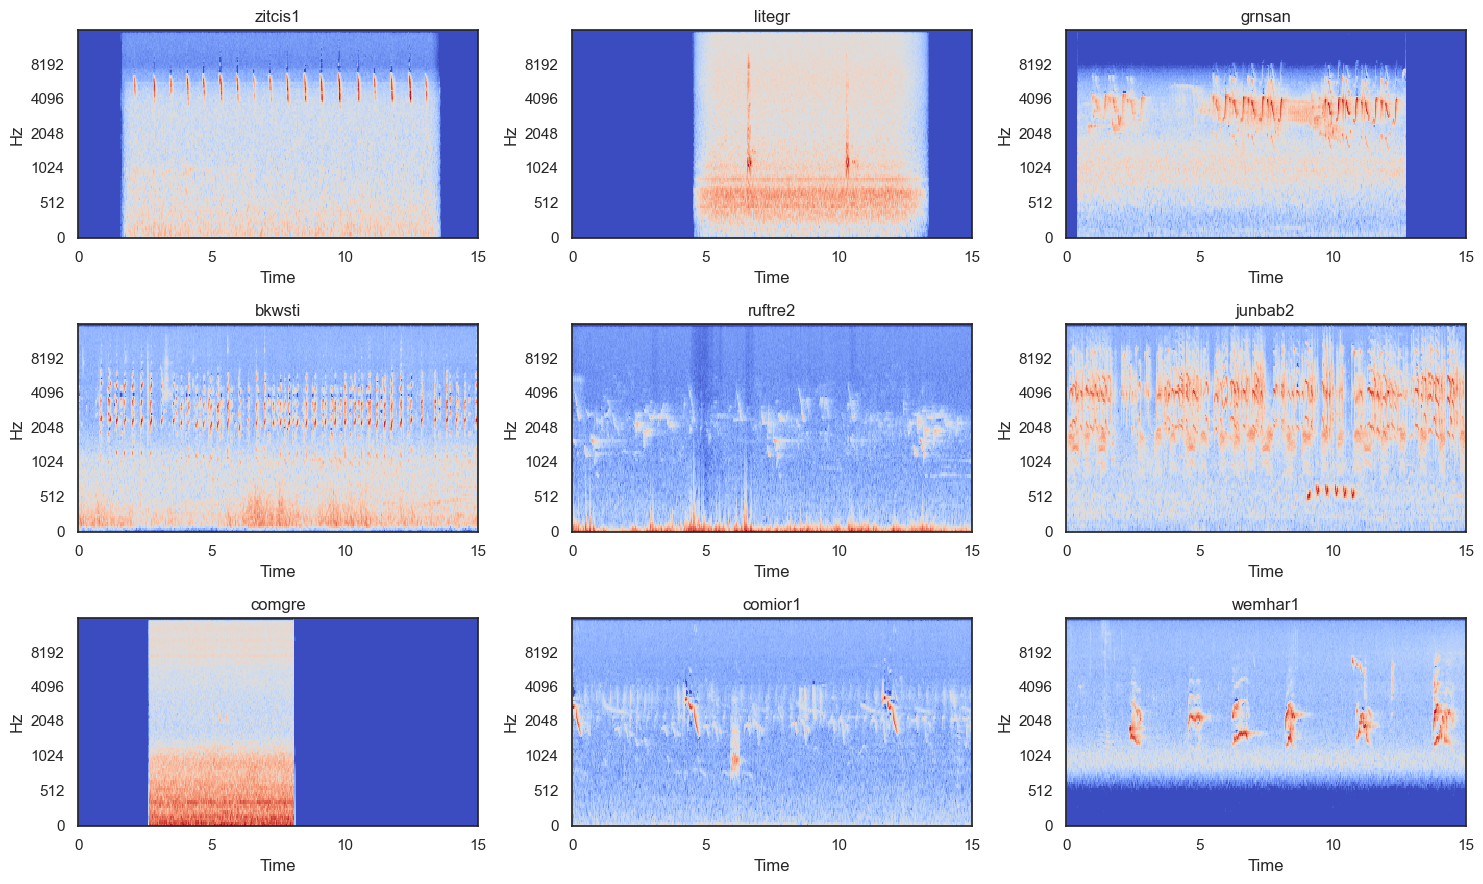

In [26]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=label2name)

In [30]:
# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))
preset = 'efficientnetv2_b2_imagenet'
# Pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=num_classes,
    name="classifier"
)(inp)
# Build model
model = keras.models.Model(inputs=inp, outputs=out)
# Compile model with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ImageClassifier)    │ (None, 182)            │     9,025,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,025,812 (34.43 MB)

 Trainable params: 8,943,524 (34.12 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [30]:

import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

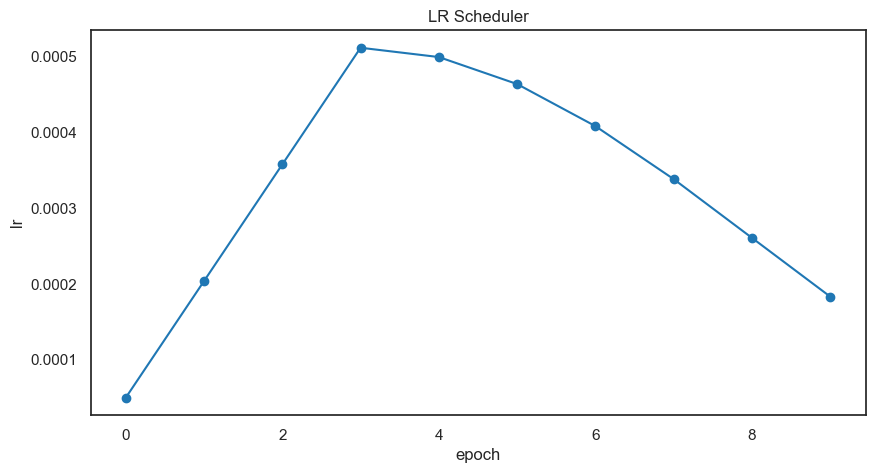

In [34]:
lr_cb = get_lr_callback(batch_size, plot=True)

In [32]:
ckpt_cb = keras.callbacks.ModelCheckpoint("spectrogram-method.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

In [35]:
epochs = 10
history = model.fit(
     train_ds, 
    validation_data=valid_ds, 
    epochs=epochs,
    callbacks=[lr_cb, ckpt_cb], 
    verbose=1
)

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2333s 8s/step - auc: 0.6348 - loss: 5.0077 - val_auc: 0.7741 - val_loss: 4.6052 - learning_rate: 5.0000e-05
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2760s 9s/step - auc: 0.7929 - loss: 4.3072 - val_auc: 0.9263 - val_loss: 2.6764 - learning_rate: 2.0400e-04
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 1740s 6s/step - auc: 0.8554 - loss: 2.7304 - val_auc: 0.9602 - val_loss: 1.8749 - learning_rate: 3.5800e-04
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 1692s 6s/step - auc: 0.8608 - loss: 2.1183 - val_auc: 0.9645 - val_loss: 1.6466 - learning_rate: 5.1200e-04
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 1714s 6s/step - auc: 0.8875 - loss: 1.6616 - val_auc: 0.9651 - val_loss: 1.5117 - learning_rate: 4.9972e-04
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 1772s 6s/step - auc: 0.8888 - loss: 1.4049 - val_auc: 0.9661 - val_loss: 1.4420 - learning_rate: 4.6406e-04
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 3947s 13s/step - auc: 0.8895 - loss: 1.2238 - val_auc: 0.9623 - val_loss

## Test on test split set

In [ ]:
## Predict on test data 
y_pred = model.predict(test_ds, verbose=1)
y_pred = y_pred.argmax(axis=1)
y_true = test_df.target.values

38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 623ms/step


array([ 37, 142,  10, ...,  82,  33,   0])

In [ ]:
## Count the number of items in test dataset
num_items = test_df.shape[0]
print(f"Number of items in test dataset: {num_items}")
## There is a discrepancy between the number of items in the test dataset and the number of predictions
## This is because the batch size is set to 64 and the test dataset has 1223 items
test_ds = build_dataset(
    paths=test_paths, 
    labels=None,  # No labels for prediction
    batch_size=1,
    shuffle=False,  # No shuffling for test to ensure consistency
    augment=False  # No augmentation for test dataset
)

## Predict on test data
y_pred = []
for batch in tqdm(test_ds, total=num_items):
    y_pred.append(model.predict(batch).argmax(axis=1))


In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7420278004905969

In [ ]:
y_pred_labels = [label2name[int(pred[0])] for pred in y_pred]
y_true_labels = [label2name[int(true)] for true in y_true]

print("Predicted labels:", y_pred_labels[:5])
print("True labels:", y_true_labels[:5])

## Plot the confusion matrix for the model
def plot_confusion_matrix(y_true, y_pred, labels, figsize=(10, 10)):
    """Plot confusion matrix for a given set of true and predicted labels."""
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm / tf.math.reduce_sum(cm, axis=1, keepdims=True)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## Call the function to plot the confusion matrix
plot_confusion_matrix(y_true, [int(pred[0]) for pred in y_pred], class_names)

In [28]:
## Create another model with a different backbone
inp = keras.layers.Input(shape=(None, None, 3))
preset = 'resnet50_imagenet'
# Pretrained backbone
backbone = keras_cv.models.ResNet50Backbone.from_preset(
    preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=num_classes,
    name="classifier"
)(inp)
# Build model
model = keras.models.Model(inputs=inp, outputs=out)
# Compile model with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
model.summary()

100%|██████████| 777/777 [00:00<00:00, 547kB/s]


100%|██████████| 90.3M/90.3M [02:36<00:00, 603kB/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ImageClassifier)    │ (None, 182)            │    23,934,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,934,070 (91.30 MB)

 Trainable params: 23,880,950 (91.10 MB)

 Non-trainable params: 53,120 (207.50 KB)

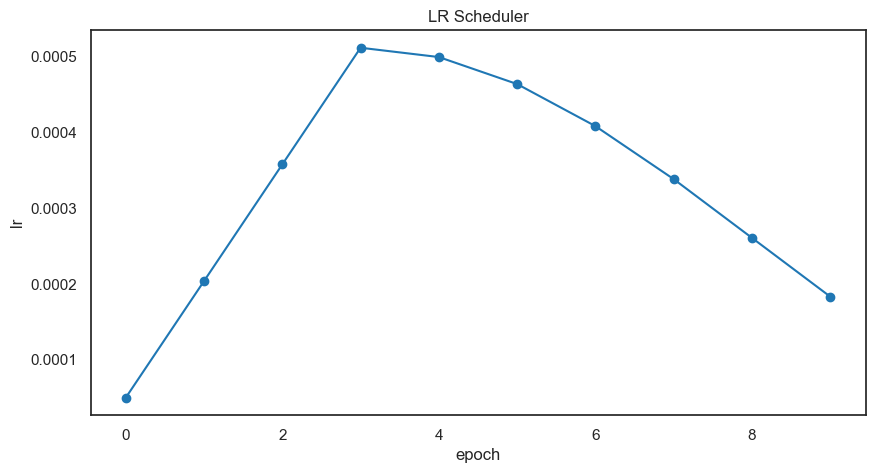

In [31]:
lr_cb = get_lr_callback(batch_size, plot=True)

In [32]:
ckpt_cb = keras.callbacks.ModelCheckpoint("resnet-method.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

In [33]:
## Train the model for 10 epochs
epochs = 10
history = model.fit(
     train_ds, 
    validation_data=valid_ds, 
    epochs=epochs,
    callbacks=[lr_cb, ckpt_cb], 
    verbose=1
)

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 3078s 10s/step - auc: 0.7167 - loss: 4.6758 - val_auc: 0.6613 - val_loss: 5.0208 - learning_rate: 5.0000e-05
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2978s 10s/step - auc: 0.8465 - loss: 2.9664 - val_auc: 0.8204 - val_loss: 4.3976 - learning_rate: 2.0400e-04
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 3032s 10s/step - auc: 0.8690 - loss: 2.0844 - val_auc: 0.9349 - val_loss: 2.5734 - learning_rate: 3.5800e-04
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2534s 8s/step - auc: 0.8746 - loss: 1.7683 - val_auc: 0.9371 - val_loss: 2.0991 - learning_rate: 5.1200e-04
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2899s 10s/step - auc: 0.8843 - loss: 1.4976 - val_auc: 0.9176 - val_loss: 2.3225 - learning_rate: 4.9972e-04
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2852s 9s/step - auc: 0.9069 - loss: 1.1478 - val_auc: 0.9303 - val_loss: 2.0807 - learning_rate: 4.6406e-04
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2639s 9s/step - auc: 0.8854 - loss: 1.0644 - val_auc: 0.9349 - val_l

In [ ]:
num_items = test_df.shape[0]
print(f"Number of items in test dataset: {num_items}")

test_ds = build_dataset(
    paths=test_paths, 
    labels=None,  # No labels for prediction
    batch_size=1,
    shuffle=False,  # No shuffling for test to ensure consistency
    augment=False  # No augmentation for test dataset
)

## Predict on test data
y_pred = []
for batch in tqdm(test_ds, total=num_items):
    y_pred.append(model.predict(batch).argmax(axis=1))

In [37]:
y_true = test_df.target.values

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.723630417007359